In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [3]:
with open("first_database.pkl", "rb")as f:
    X,y=pickle.load(f)

In [4]:
# parameters
n = 100
m = 10
a = 5 # nb of agents
sigma = 0.5
nu = 1.0

In [5]:
sel = list(range(n))
ind = np.random.choice(sel,m,replace=False)
x_selected = X[ind] # ids_M
ind

array([26,  5, 63, 73, 71, 48, 42, 70,  3, 27])

In [6]:
from utils.kernel import kernel_matrix
Kmm = kernel_matrix(X, ind, ind)
Knm = kernel_matrix(X, sel, ind)

ModuleNotFoundError: No module named 'utils'

In [ ]:
sel_copy = np.arange(n)
np.random.shuffle(sel_copy)
agents = np.array_split(sel_copy, a)

In [7]:
agents

NameError: name 'agents' is not defined

In [ ]:
def grad_fi(dataY, Kmm, Knm, alpha, ids_agent):
    Kim = Knm[ids_agent, :]
    return sigma**2/5*Kmm@alpha + Kim.T@(Kim@alpha - dataY[ids_agent]) + nu/5*alpha 

In [ ]:
import networkx as nx
from utils.graph_tools import metropolis_weight_matrix, laplacian_weight_matrix
# from kernel import grad_fi

step_size = 0.002
step_count = 100000

G = nx.cycle_graph(a)
W = laplacian_weight_matrix(G, 0.1) # check the matrices
xi = np.random.normal(0, 0.01, size=(step_count+1, a, m))
g = np.zeros((step_count+1, a, m))
# local gradients
for i, id_agent in enumerate(agents):
    g[0, i, :] = grad_fi(y, Kmm, Knm, xi[0,i,:], id_agent)

for k in range(step_count):
    xi[k+1, :, :] = W@xi[k, :, :] - step_size*g[k, :, :] # note that W is symetric so W.T doesn't matter
    g[k+1, :, :] = W@g[k,:,:]
    for i, id_agent in enumerate(agents):
        g[k+1, i, :] += \
            + grad_fi(y, Kmm, Knm, xi[k+1,i, :], id_agent) \
            - grad_fi(y, Kmm, Knm, xi[k,i,:], id_agent)


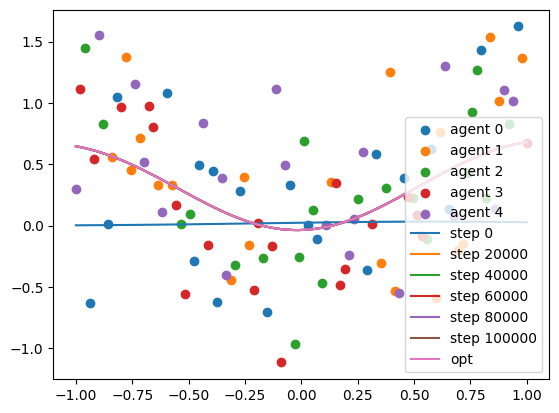

In [ ]:
# plt.scatter(x[sel], y[sel])
from utils.kernel import calc_alpha_opt

for i in range(a):
    plt.scatter(X[agents[i]], y[agents[i]], label="agent %d"%(i))

from utils.kernel import calc_f
nt = 250
x_linspace = np.linspace(-1, 1, nt)
for s in range(0, step_count+1, step_count // 5):
    pred = [calc_f(X, ind, v, xi[s, 0, :]) for v in x_linspace]
    plt.plot(x_linspace, pred, label="step %d" % s)

opt = [calc_f(X, ind, v, calc_alpha_opt(Kmm, Knm, y[:n])) for v in x_linspace]
plt.plot(x_linspace, opt, label="opt")

plt.legend()
plt.show()

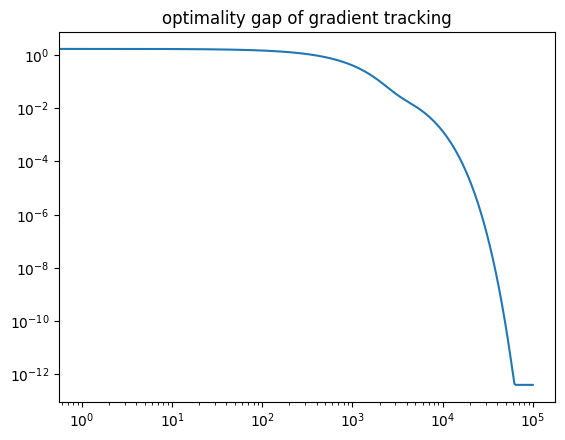

In [ ]:
from utils.kernel import calc_alpha_opt


def plot_optimality_gap(Kmm, Knm, y, alphas_over_time):
    alpha_opt = calc_alpha_opt(Kmm, Knm, y)
    opt_gap = [np.sqrt(np.sum((alpha_opt - alphas_over_time[i,:])**2)) 
               for i in range(alphas_over_time.shape[0])]

    plt.xscale("log")
    plt.yscale("log")
    plt.plot(opt_gap)
    plt.title("optimality gap of gradient tracking")
    plt.show()
        
plot_optimality_gap(Kmm, Knm, y[:n], xi[:, 0, :])